In [46]:
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import seaborn as sns
import matplotlib.pyplot as plt
import nilearn.datasets
import nilearn.image
import nilearn.datasets as nds
import nilearn.image as nim
import torch
from torch.utils.data import Dataset
from data import *

In [47]:
# better plots
sns.set_style("whitegrid")

In [48]:
# config
FEATURES_PATH = "data/ds001246//derivatives/preproc-spm/output/"
TARGETS_PATH = "data/ds001246//"
TRAIN_CATEGORIES_PATH = "data/ds001246//stimulus_ImageNetTraining.csv"
TEST_CATEGORIES_PATH = "data/ds001246//stimulus_ImageNetTest.csv"

In [49]:
import glob
import numpy as np
import pandas as pd
import nibabel as nib

import torch
from torch.utils.data import Dataset

# dataset class for the GenericObjectDecoding dataset
class GODData(Dataset):
    FEATURES_PATH = "data/ds001246/derivatives/preproc-spm/output"
    TARGETS_PATH = "data/ds001246"
    TRAIN_CATEGORIES_PATH = "data/ds001246/stimulus_ImageNetTraining.csv"
    TEST_CATEGORIES_PATH = "data/ds001246/stimulus_ImageNetTest.csv"

    def __init__(
            self, 
            subject="01", 
            session_id="01", 
            task="perception", 
            train=True,
            limit_size=None,
        ):
        session = f"{task}{'Training' if train else 'Test'}{session_id}"

        # load data
        feature_runs = sorted(glob.glob(f"{self.FEATURES_PATH}/sub-{subject}/ses-{session}/func/*"))
        target_runs = sorted(glob.glob(f"{self.TARGETS_PATH}/sub-{subject}/ses-{session}/func/*events*"))
        categories = pd.read_csv(self.TRAIN_CATEGORIES_PATH if train else self.TEST_CATEGORIES_PATH, sep="\t", header=None)

        # process features and targets
        features = []
        targets = []

        for f_run, t_run in zip(feature_runs, target_runs):
            features_run = nib.load(f_run).get_fdata()
            targets_run = pd.read_csv(t_run, sep="\t")

            # remove resting states
            features_run_pp = features_run[:, :, :, 8:-2]
            targets_run_pp = targets_run[targets_run["event_type"] != "rest"]

            # reshape features into (N, C, D, W, H)
            features_run_pp = features_run_pp.transpose(3, 2, 1, 0).reshape(-1, 3, 50, 64, 64)

            # extract category labels
            targets_run_pp = targets_run_pp.merge(categories, left_on="stim_id", right_on=1)[2]
            targets_run_pp = targets_run_pp.to_numpy().reshape(-1, 1)

            features.append(features_run_pp)
            targets.append(targets_run_pp)

        features = np.vstack(features)
        targets = np.vstack(targets)

        # convert and store as tensors
        self.features = torch.from_numpy(features).float()
        self.targets = torch.from_numpy(targets).long() - 1

        # flatten targets
        self.targets = self.targets.squeeze()

        # limit dataset size
        if limit_size is not None:
            self.features = self.features[:limit_size]
            self.targets = self.targets[:limit_size]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        target = self.targets[index]
        return feature, target

In [50]:
data = GODData(subject="01", session_id="01", task="perception", train=True)

In [51]:
data.features.shape

torch.Size([550, 3, 50, 64, 64])

In [52]:
data2 = data[0][0][0]
data2.shape

torch.Size([50, 64, 64])

In [53]:
# Load the AAL atlas
aal = datasets.fetch_atlas_aal()
aal_img = image.load_img(aal.maps)
# Create an empty array to store the binary masks
masks = np.zeros(data2.shape)
print('mask_shape : ',  masks.shape)
# Iterate over each brain region in the AAL atlas
for i in range(1, int(data2.max())+1):
    # Create a binary mask for the current brain region
    masks[data2 == i] = i

# Apply the masks to the data
masked_data = np.zeros((aal_img.shape[-1],) + data2.shape[1:])
for i in range(aal_img.shape[-1]):
    masked_data[i] = data2 * (masks[..., i] == i+1)

mask_shape :  (50, 64, 64)


ValueError: operands could not be broadcast together with shapes (50,64,64) (50,64) 

In [28]:
# Assign the masks to the corresponding brain regions
V1d, V1v, V2d, V2v, V3d, V3v, V4, LOC, FFA, PPA, HVC = masks

NameError: name 'masks' is not defined

In [29]:
aal

{'description': 'AAl atlas for SPM 12\n\n\nNotes\n-----\nThis atlas is the result of an automated anatomical parcellation of the spatially normalized single-subject high-resolution T1 volume provided by the Montreal Neurological Institute (MNI) (D. L. Collins et al., 1998, Trans. Med. Imag. 17, 463-468, PubMed).\n\nUsing this parcellation method, three procedures to perform the automated anatomical labeling of functional studies are proposed: (1) labeling of an extremum defined by a set of coordinates, (2) percentage of voxels belonging to each of the AVOI intersected by a sphere centered by a set of coordinates, and (3) percentage of voxels belonging to each of the AVOI intersected by an activated cluster.\n\n\nContent\n-------\n    :"regions": str. path to nifti file containing regions.\n    :"labels": dict. labels dictionary with their region id as key and name as value\n\n\nReferences\n-----\nFor more information on this dataset\'s structure, see\nhttp://www.gin.cnrs.fr/AAL-217?lan

In [54]:
aal_img.shape

(91, 109, 91)

In [55]:
data.shape

AttributeError: 'GODData' object has no attribute 'shape'

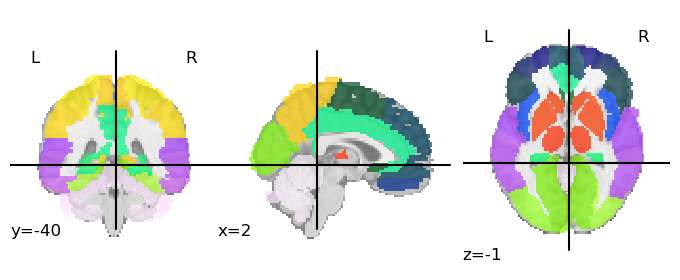

In [56]:
from nilearn import plotting
plotting.plot_roi(aal_img)

In [58]:
aal_img.shape

(91, 109, 91)

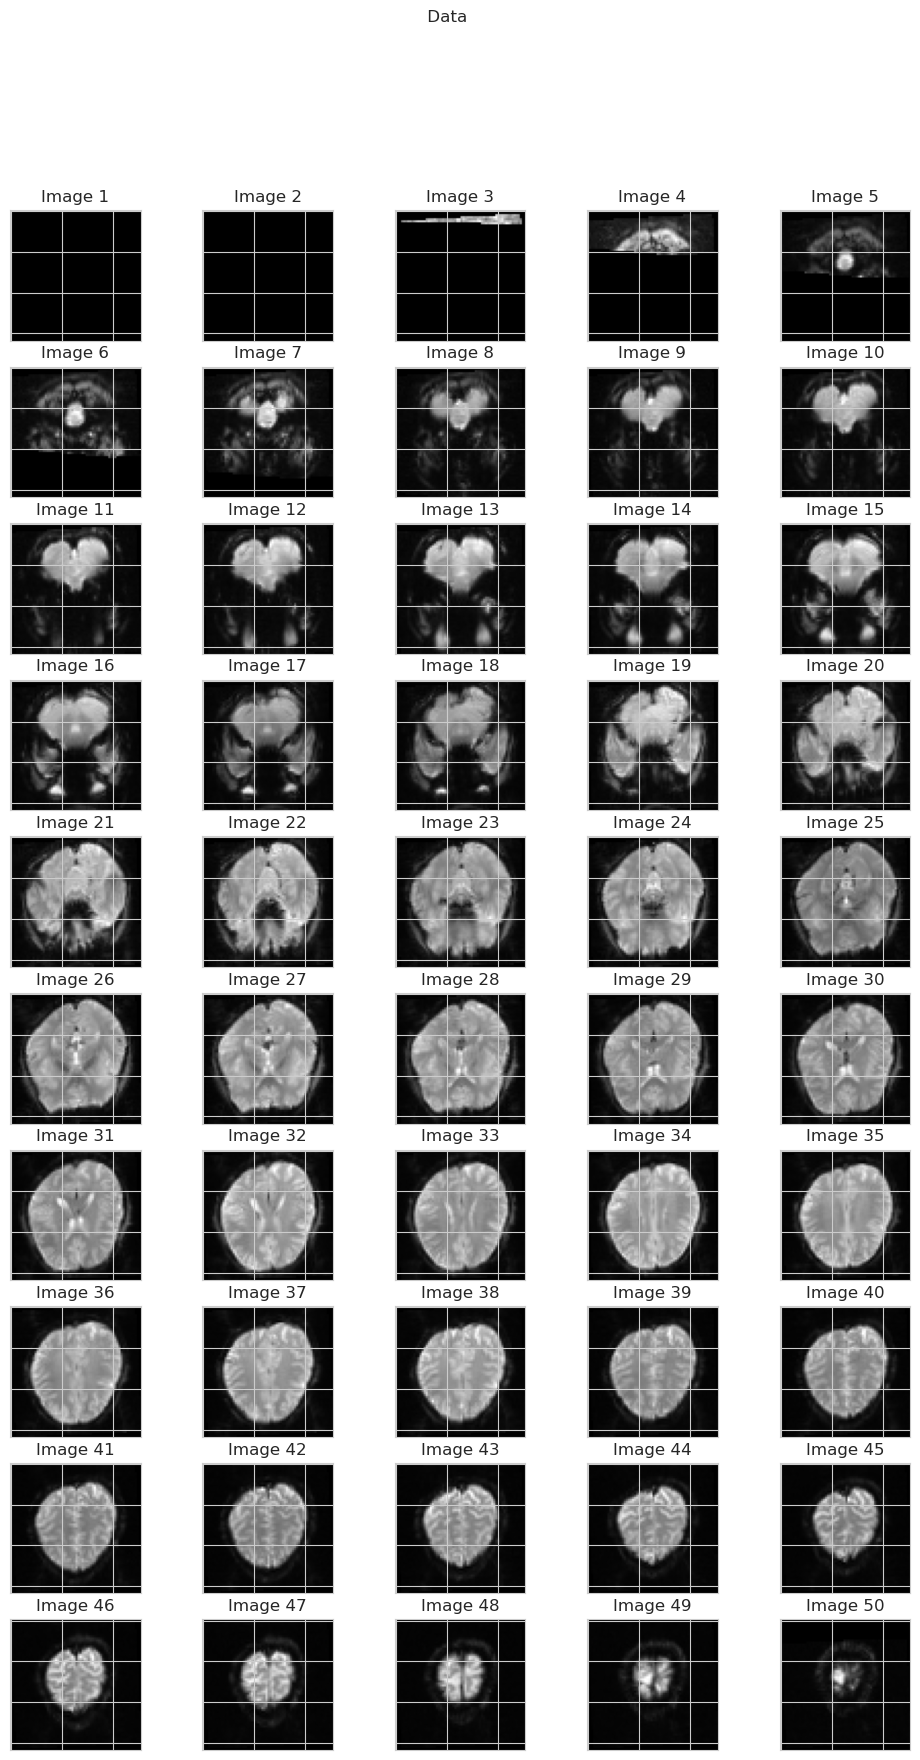

In [60]:
import matplotlib.pyplot as plt

# Create a 10x5 grid of subplots
fig, axs = plt.subplots(10, 5, figsize=(12, 20))

# Flatten the axs array to easily iterate over it
axs = axs.flatten()

# Iterate over each image and plot it in a subplot
for i in range(data2.shape[0]):
    axs[i].imshow(data2[i], cmap='gray')
    axs[i].set_title(f"Image {i+1}")

# Hide the x and y axis labels for all subplots
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Set a suptitle for the whole figure
fig.suptitle(" Data")

# Show the plot
plt.show()

In [61]:
aal

{'description': 'AAl atlas for SPM 12\n\n\nNotes\n-----\nThis atlas is the result of an automated anatomical parcellation of the spatially normalized single-subject high-resolution T1 volume provided by the Montreal Neurological Institute (MNI) (D. L. Collins et al., 1998, Trans. Med. Imag. 17, 463-468, PubMed).\n\nUsing this parcellation method, three procedures to perform the automated anatomical labeling of functional studies are proposed: (1) labeling of an extremum defined by a set of coordinates, (2) percentage of voxels belonging to each of the AVOI intersected by a sphere centered by a set of coordinates, and (3) percentage of voxels belonging to each of the AVOI intersected by an activated cluster.\n\n\nContent\n-------\n    :"regions": str. path to nifti file containing regions.\n    :"labels": dict. labels dictionary with their region id as key and name as value\n\n\nReferences\n-----\nFor more information on this dataset\'s structure, see\nhttp://www.gin.cnrs.fr/AAL-217?lan